# Stacking of models into two layers
1. First layer: train models on the whole training set
2. Second layer: train a model on the first layer's predictions and the rest of the training set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
import pandas as pd

from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost

You should consider upgrading via the 'c:\Users\gunna\Documents\Maskinlæring\Prosjekt\power-predictor\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Configure running

In [2]:
load_xgb: bool = False
load_lgb: bool = False
load_cat: bool = False
load_rf: bool = False

## Get the data

In [3]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

X_test_estimated_a.shape = (2880, 47), X_test_estimated_b.shape = (2880, 47), X_test_estimated_c.shape = (2880, 47)
After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 46), X_test_estimated_b_processed.shape = (720, 46), X_test_estimated_c_processed.shape = (720, 46)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain
0,15.2,1.18175,1.351672e+06,440.600006,7231.174805,0.0,291.250000,95.500000,294605.53125,271.225006,872357.56250,54.224998,1.0,0.0,0.0,0.0,1007.500000,0.0,0.0,72.375000,92.172501,0.00,294.625000,98.925003,48152.375000,2.125,-2.000,-0.750,0.0,1,0,0,0.027950,-0.999609,1.000000,6.123234e-17,25901.988281,0.455669,0.645392,0.0,0.548142,1,366.725006,0,0,0
1,13.7,1.19250,2.456032e+06,637.599976,1410.500000,0.0,289.399994,145.525009,447652.68750,5.800000,11749.87500,99.675003,1.0,0.0,0.0,0.0,1001.400024,0.0,0.1,80.699997,236.257751,0.10,292.100006,100.000000,5903.875000,1.350,-1.225,0.525,0.0,0,1,0,-0.310857,-0.950457,-0.500000,-8.660254e-01,844.045105,0.611489,0.004784,0.0,0.996750,1,151.325012,0,0,0
2,10.5,1.20150,2.172293e+05,107.400002,2315.000000,0.0,285.299988,42.200001,100314.65625,65.099998,135992.90625,23.299999,1.0,0.0,0.0,0.0,1006.849976,0.0,0.0,59.049999,85.390503,0.00,291.700012,43.549999,49974.699219,3.375,-0.400,3.350,0.0,1,0,0,-0.804826,-0.593511,0.965926,2.588190e-01,2747.219971,0.164161,0.626034,0.0,0.535017,0,107.300003,0,0,0
3,6.3,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.00000,0.000000,0.00000,99.574997,0.0,1.0,0.0,0.0,992.949951,0.0,0.0,93.650002,127.701752,0.35,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-2.588190e-01,0.000000,0.000000,0.000000,0.0,0.995999,1,0.000000,0,0,0
4,6.3,1.27175,0.000000e+00,0.000000,8580.474609,0.0,277.000000,0.000000,0.00000,0.000000,0.00000,49.400002,0.0,1.0,0.0,0.0,1012.200012,0.0,0.0,81.649994,346.724243,0.00,278.600006,98.824997,27873.150391,1.450,1.450,-0.275,0.0,1,0,0,0.931210,-0.364483,-0.500000,8.660254e-01,0.000000,0.000000,0.000000,0.0,0.499874,1,0.000000,0,0,0


## Train test split for the base layer and meta layer

In [4]:
# The base layer gets 80% of the data
# The meta layer gets 20% of the data
base_to_meta_layer_split = 0.8

base_x_train = x_whole.sample(frac=base_to_meta_layer_split)
meta_x_train = x_whole.sample(frac=1-base_to_meta_layer_split)

# Get the corresponding y values
base_y_train = y_whole[base_x_train.index]
meta_y_train = y_whole[meta_x_train.index]
base_x_train.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'is_day:idx', 'is_in_shadow:idx',
       'precip_5min:mm', 'precip_type_5min:idx', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sun_azimuth:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'location_a', 'location_b', 'location_c', 'sin_day_of_year',
       'cos_day_of_year', 'sin_hour', 'cos_hour', 'sun_product',
       'modified_solar_elevation', 'effective_radiation',
       'time_since_prediction', 'cloud_ratio', 'cloud_cover_over_30%',
       'sun_addition', 'is_freezing', 'is_snow', 'is_rain

# Train Base level models
It is important to use a variety of models to get a diverse set of predictions.

I want a model to check if there is a linear relationship between the location features and the target. I will use a linear regression model for this.
I want to check if the different irradiation values are correlated with the target. I will use xgboost for this.
I want to check if the different temperature values are correlated with the target. I will use 


## XGBoost
The XGBoost model is a gradient boosting model. It is a tree based model that uses the gradient descent algorithm to minimize the loss function. The loss function is a combination of the training loss and a regularization term. The regularization term is used to prevent overfitting. The model is trained on the training set and the validation set is used to check if the model is overfitting. The model is then trained on the whole training set and the test set is used to check the model's performance.

Utilizing k-fold cross validation to train the model on different subsets of the training set and validate on the rest of the training set. This is done to prevent overfitting.

In [5]:
# K-fold cross validation
if not load_xgb:
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0

    xgboost_models = []


    for train_index, test_index in kf.split(base_x_train):
        reg = xgb.XGBRegressor(n_estimators=10000000,
                        early_stopping_rounds=50,
                        learning_rate= 0.001,
                        objective="reg:linear",
                        eval_metric="mae",
                        sub_sample = 0.9,
                        colsample_bytree = 1.0,
                        gamma = 0,
                        min_child_weight=0,
                        max_depth=9)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Create sample weights for training data
        sample_weight_train = np.where(X_train['time_since_prediction'] == 0, 1, 2)
        # Create sample weights for testing data
        sample_weight_test = np.where(X_test['time_since_prediction'] == 0, 1, 2)
        
        reg.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                sample_weight=sample_weight_train,
                sample_weight_eval_set=[sample_weight_test],  # Here's how you pass the eval weights
                verbose=100)
        
        xgboost_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions, sample_weight=sample_weight_test)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

[0]	validation_0-mae:411.95149
[100]	validation_0-mae:375.11245
[200]	validation_0-mae:342.20129
[300]	validation_0-mae:312.77299
[400]	validation_0-mae:286.73286
[500]	validation_0-mae:263.71045
[600]	validation_0-mae:243.40801
[700]	validation_0-mae:225.40843
[800]	validation_0-mae:209.40668
[900]	validation_0-mae:195.21899
[1000]	validation_0-mae:182.59338
[1100]	validation_0-mae:171.41181
[1200]	validation_0-mae:161.51118
[1300]	validation_0-mae:152.76618
[1400]	validation_0-mae:144.97334
[1500]	validation_0-mae:138.01862
[1600]	validation_0-mae:131.77802
[1700]	validation_0-mae:126.21990
[1800]	validation_0-mae:121.29331
[1900]	validation_0-mae:116.88320
[2000]	validation_0-mae:112.87260
[2100]	validation_0-mae:109.29799
[2200]	validation_0-mae:106.10800
[2300]	validation_0-mae:103.24876
[2400]	validation_0-mae:100.68918
[2500]	validation_0-mae:98.38331
[2600]	validation_0-mae:96.31167
[2700]	validation_0-mae:94.46416
[2800]	validation_0-mae:92.77708
[2900]	validation_0-mae:91.295

## Catboost

In [6]:
if not load_cat:
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0
    catboost_models = []

    def compute_sample_weight(data):
        # Assign weight of 2 for estimated data and 1 for observed data
        return np.where(data['time_since_prediction'] > 0, 2, 1)

    for train_index, test_index in kf.split(base_x_train):
        reg = CatBoostRegressor(
            iterations=10000000,
            depth=8,
            learning_rate=0.001,
            loss_function='MAE',
            verbose=200
        )
        
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Compute sample weights for training and testing data
        train_weight = compute_sample_weight(X_train)
        test_weight = compute_sample_weight(X_test)

        # Create Pool for training and testing
        train_pool = Pool(data=X_train, label=y_train, weight=train_weight)
        test_pool = Pool(data=X_test, label=y_test, weight=test_weight)

        # Fit the model using the sample weights
        reg.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

        catboost_models.append(reg)
        predictions = reg.predict(test_pool)
        
        # Compute weighted MAE manually
        weighted_mae = np.sum(test_weight * np.abs(y_test - predictions)) / np.sum(test_weight)
        total_mae += weighted_mae
        
        print(f"Fold {len(catboost_models)}, Weighted Mean Absolute Error: {weighted_mae}")

    average_mae = total_mae / num_folds
    print(f"Average Weighted Mean Absolute Error: {average_mae}")


0:	learn: 287.1142779	test: 278.5035815	best: 278.5035815 (0)	total: 198ms	remaining: 22d 22h 12m 30s
200:	learn: 252.0510298	test: 243.8886638	best: 243.8886638 (200)	total: 7.61s	remaining: 4d 9h 13m 36s
400:	learn: 219.9912839	test: 212.3067204	best: 212.3067204 (400)	total: 14.7s	remaining: 4d 5h 55m 7s
600:	learn: 192.8297336	test: 185.7117780	best: 185.7117780 (600)	total: 21.6s	remaining: 4d 3h 42m 51s
800:	learn: 171.0006240	test: 164.4306847	best: 164.4306847 (800)	total: 28.5s	remaining: 4d 2h 49m 16s
1000:	learn: 154.5996163	test: 148.3508748	best: 148.3508748 (1000)	total: 35.5s	remaining: 4d 2h 27m 56s
1200:	learn: 141.0920262	test: 135.2382595	best: 135.2382595 (1200)	total: 42.4s	remaining: 4d 2h 8m 12s
1400:	learn: 131.1133175	test: 125.6258449	best: 125.6258449 (1400)	total: 49.2s	remaining: 4d 1h 29m 1s
1600:	learn: 123.1249660	test: 118.0159979	best: 118.0159979 (1600)	total: 55.9s	remaining: 4d 54m 48s
1800:	learn: 116.3656518	test: 111.5372293	best: 111.5372293 (18

## lightgbm

In [7]:
if not load_lgb:
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    total_mae = 0

    lightgbm_models = []

    params = {
        'objective': 'regression_l1',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'metric': 'mae',
        'num_leaves': 128,
        'learning_rate': 0.001,
        'feature_fraction': 1.0,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'min_data_in_leaf': 20,
        'early_stopping_rounds': 100,
        'verbosity': -1,  # 0 for verbose, -1 for silent
    }

    num_round = 10000000 # number of training iterations

    # Ensure column names are compatible with LightGBM
    base_x_train.columns = base_x_train.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

    for train_index, test_index in kf.split(base_x_train):
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test)

        reg = lgb.train(params, train_data, num_round, valid_sets=[valid_data])
        lightgbm_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

Fold 79.74225367186554, Mean Absolute Error: 79.74225367186554
Fold 155.68952500380902, Mean Absolute Error: 75.94727133194347
Fold 235.36306972167094, Mean Absolute Error: 79.67354471786192
Fold 305.7135028521018, Mean Absolute Error: 70.35043313043086
Fold 390.72650058306704, Mean Absolute Error: 85.01299773096524
Average Mean Squared Error: 78.14530011661341


## Random Forest

In [13]:
if not load_rf:
    # K-fold cross validation
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0

    random_forest_models = []


    for train_index, test_index in kf.split(base_x_train):

        rf_model = RandomForestRegressor(n_estimators=200, max_depth=25, random_state=42)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        # Train the Random Forest model on the cleaned training data
        
        rf_model.fit(X_train, y_train)
        
        random_forest_models.append(rf_model)
        predictions = rf_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

Fold 84.49629039882784, Mean Absolute Error: 84.49629039882784
Fold 166.31408298521268, Mean Absolute Error: 81.81779258638483
Fold 251.57454435308745, Mean Absolute Error: 85.26046136787477
Fold 335.7139906317509, Mean Absolute Error: 84.13944627866347
Fold 426.17175719374825, Mean Absolute Error: 90.45776656199736
Average Mean Squared Error: 85.23435143874966


### load the models and save the newly trained models

In [14]:
# Check what models should be loaded
# Load XGBoost models
if load_xgb:
    with open("xgboost_models_stack.pkl", "rb") as file:
        xgboost_models = pickle.load(file)
        print(f"[LOADED] xgboost_models {len(xgboost_models)} has successfully been loaded")
else:
    with open("xgboost_models_stack.pkl", "wb") as file:
        pickle.dump(xgboost_models, file)
        print(f"[SAVED] xgboost_models has successfully been saved.")

# Load CatBoost models
if load_cat:
    with open("catboost_models_stack.pkl", "rb") as file:
        catboost_models = pickle.load(file)
        print(f"[LOADED] catboost_models {len(catboost_models)} has successfully been loaded")
else:
    with open("catboost_models_stack.pkl", "wb") as file:
        pickle.dump(catboost_models, file)
        print(f"[SAVED] catboost_models has successfully been saved.")

# Load lightGBM models
if load_lgb:
    with open("lightgbm_models_stack.pkl", "rb") as file:
        lightgbm_models = pickle.load(file)
        print(f"[LOADED] lightgbm_models {len(lightgbm_models)} has successfully been loaded")
else:
    with open("lightgbm_models_stack.pkl", "wb") as file:
        pickle.dump(lightgbm_models, file)
        print(f"[SAVED] lightgbm_models has successfully been saved.")

# Load random forest models
if load_rf:
    with open("random_forest_models_stack.pkl", "rb") as file:
        random_forest_models = pickle.load(file)
        print(f"[LOADED] random_forest_models {len(random_forest_models)} has successfully been loaded")
else:
    with open("random_forest_models_stack.pkl", "wb") as file:
        pickle.dump(random_forest_models, file)
        print(f"[SAVED] random_forest_models has successfully been saved.")


[SAVED] xgboost_models has successfully been saved.
[SAVED] catboost_models has successfully been saved.
[SAVED] lightgbm_models has successfully been saved.
[SAVED] random_forest_models has successfully been saved.


In [15]:
def average_prediction(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


# Train meta learner model

Create dataset for meta learner model by using models to predict on the meta layer training set

In [17]:
# Predict on the base layer on meta_x_train
base_xgboost_predictions  = average_prediction(meta_x_train, xgboost_models)
base_catboost_predictions = average_prediction(meta_x_train, catboost_models)
base_lightgbm_predictions = average_prediction(meta_x_train, lightgbm_models)
# base_random_forest_predictions = average_prediction(meta_x_train, random_forest_models)

# Add the predictions to the meta_x_train
meta_base_x_train = pd.DataFrame()
meta_base_x_train["xgboost"] = base_xgboost_predictions
meta_base_x_train["catboost"] = base_catboost_predictions
meta_base_x_train["lightgbm"] = base_lightgbm_predictions
# meta_base_x_train["random_forest"] = base_random_forest_predictions

Train meta learner model on new dataset

In [18]:
# K-fold cross validation

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

meta_models = []


for train_index, test_index in kf.split(meta_base_x_train):

    reg = xgb.XGBRegressor(n_estimators=100000,
                       early_stopping_rounds=50,
                       learning_rate= 0.01,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       alpha = 0.001,
                       min_child_weight=0,
                       max_depth=4)

    X_train, X_test = meta_base_x_train.iloc[train_index], meta_base_x_train.iloc[test_index]
    y_train, y_test = meta_y_train.iloc[train_index], meta_y_train.iloc[test_index]

    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=100)
    
    meta_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")

[0]	validation_0-mae:440.42829
[100]	validation_0-mae:176.36645
[200]	validation_0-mae:86.94188
[300]	validation_0-mae:57.49320
[400]	validation_0-mae:48.82564
[500]	validation_0-mae:45.33246
[600]	validation_0-mae:43.61365
[700]	validation_0-mae:42.80774
[800]	validation_0-mae:42.44967
[900]	validation_0-mae:42.22543
[1000]	validation_0-mae:42.09070
[1100]	validation_0-mae:41.97385
[1200]	validation_0-mae:41.95917
[1231]	validation_0-mae:41.95863
Fold 41.94738745443283, Mean Absolute Error: 41.94738745443283
[0]	validation_0-mae:419.69117
[100]	validation_0-mae:165.03743
[200]	validation_0-mae:82.39442
[300]	validation_0-mae:55.34847
[400]	validation_0-mae:46.80342
[500]	validation_0-mae:43.51577
[600]	validation_0-mae:41.87961
[700]	validation_0-mae:41.04249
[800]	validation_0-mae:40.52877
[900]	validation_0-mae:40.23702
[1000]	validation_0-mae:39.97863
[1100]	validation_0-mae:39.78110
[1200]	validation_0-mae:39.62524
[1300]	validation_0-mae:39.59387
[1398]	validation_0-mae:39.58538


<Figure size 10000x10000 with 0 Axes>

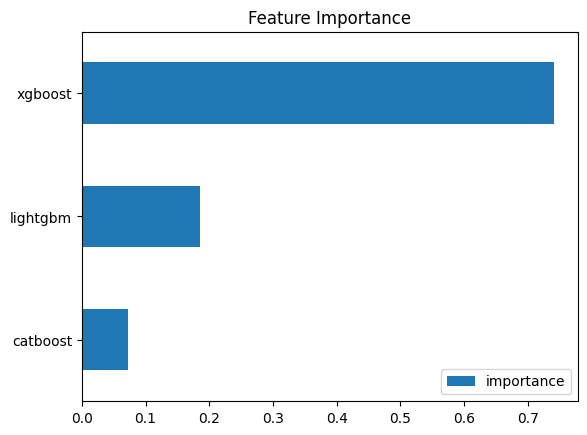

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(100,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [20]:
y_pred_val_obs_combined = average_prediction(X_val_obs_combined, meta_models)
y_pred_val_est_combined = average_prediction(X_val_est_combined, meta_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


ValueError: feature_names mismatch: ['xgboost', 'catboost', 'lightgbm'] ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'is_day:idx', 'is_in_shadow:idx', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sun_azimuth:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'location_a', 'location_b', 'location_c', 'sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour', 'sun_product', 'modified_solar_elevation', 'effective_radiation', 'time_since_prediction', 'cloud_ratio', 'cloud_cover_over_30%', 'sun_addition', 'is_freezing', 'is_snow', 'is_rain']
expected catboost, xgboost, lightgbm in input data
training data did not have the following fields: pressure_50m:hPa, wind_speed_v_10m:ms, visibility:m, is_snow, diffuse_rad:W, diffuse_rad_1h:J, cos_hour, direct_rad:W, is_freezing, relative_humidity_1000hPa:p, total_cloud_cover:p, location_a, t_1000hPa:K, rain_water:kgm2, sin_hour, wind_speed_u_10m:ms, prob_rime:p, dew_or_rime:idx, cloud_ratio, is_rain, sin_day_of_year, effective_cloud_cover:p, sun_addition, clear_sky_rad:W, is_in_shadow:idx, air_density_2m:kgm3, precip_5min:mm, sun_azimuth:d, dew_point_2m:K, cloud_base_agl:m, cos_day_of_year, direct_rad_1h:J, location_c, wind_speed_w_1000hPa:ms, precip_type_5min:idx, absolute_humidity_2m:gm3, effective_radiation, time_since_prediction, super_cooled_liquid_water:kgm2, is_day:idx, location_b, modified_solar_elevation, cloud_cover_over_30%, clear_sky_energy_1h:J, sun_product, wind_speed_10m:ms

## Get predictions for meta learner model test set

In [23]:
# Predict on the base layer on meta_x_train
base_xgboost_predictions  = average_prediction(x_test_whole, xgboost_models)
base_catboost_predictions = average_prediction(x_test_whole, catboost_models)
base_lightgbm_predictions = average_prediction(x_test_whole, lightgbm_models)
# base_random_forest_predictions = average_prediction(meta_x_train, random_forest_models)

# Add the predictions to the meta_x_train
meta_base_x_train = pd.DataFrame()
meta_base_x_train["xgboost"] = base_xgboost_predictions
meta_base_x_train["catboost"] = base_catboost_predictions
meta_base_x_train["lightgbm"] = base_lightgbm_predictions

In [25]:
# Predict on the cleaned validation set
y_predictions = average_prediction(meta_base_x_train, meta_models)

## Save predictions

In [28]:
from src.models.saving import save_predictions
from src.features.postprocess_data import postprocess_data
y_predictions = postprocess_data(x_test_whole, pd.Series(y_predictions))
save_predictions(y_predictions, 'stacking test1')

hour: 0, min_value_a: 0.0, max_value_a: 3.3, min_value_b: -0.0, max_value_b: -0.0, min_value_c: 0.0, max_value_c: 0.0
hour: 1, min_value_a: 0.0, max_value_a: 53.68, min_value_b: -0.0, max_value_b: 12.075, min_value_c: 0.0, max_value_c: 9.8
hour: 2, min_value_a: 0.0, max_value_a: 233.64000000000001, min_value_b: -0.0, max_value_b: 68.1375, min_value_c: 0.0, max_value_c: 39.2
hour: 3, min_value_a: 0.0, max_value_a: 439.12, min_value_b: -0.0, max_value_b: 138.0, min_value_c: 0.0, max_value_c: 88.2
hour: 4, min_value_a: 0.0, max_value_a: 1046.98, min_value_b: -0.0, max_value_b: 307.05, min_value_c: 0.0, max_value_c: 176.4
hour: 5, min_value_a: 0.0, max_value_a: 2049.08, min_value_b: -0.0, max_value_b: 452.8125, min_value_c: 0.0, max_value_c: 264.6
hour: 6, min_value_a: 0.0, max_value_a: 3244.78, min_value_b: -0.0, max_value_b: 681.375, min_value_c: 0.0, max_value_c: 499.8
hour: 7, min_value_a: 0.0, max_value_a: 4266.46, min_value_b: -0.0, max_value_b: 865.0875, min_value_c: 0.0, max_value_